# IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# LOAD AND PREPARE DATA

In [2]:
df = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col=['Month'])

# PLOT DATA

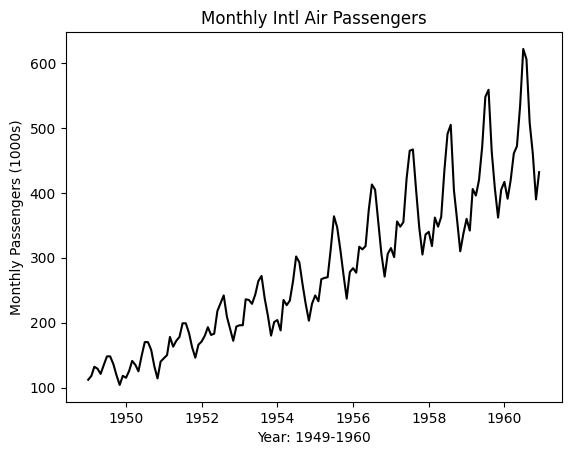

In [3]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(df, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# DECOMPOSE TIME SERIES

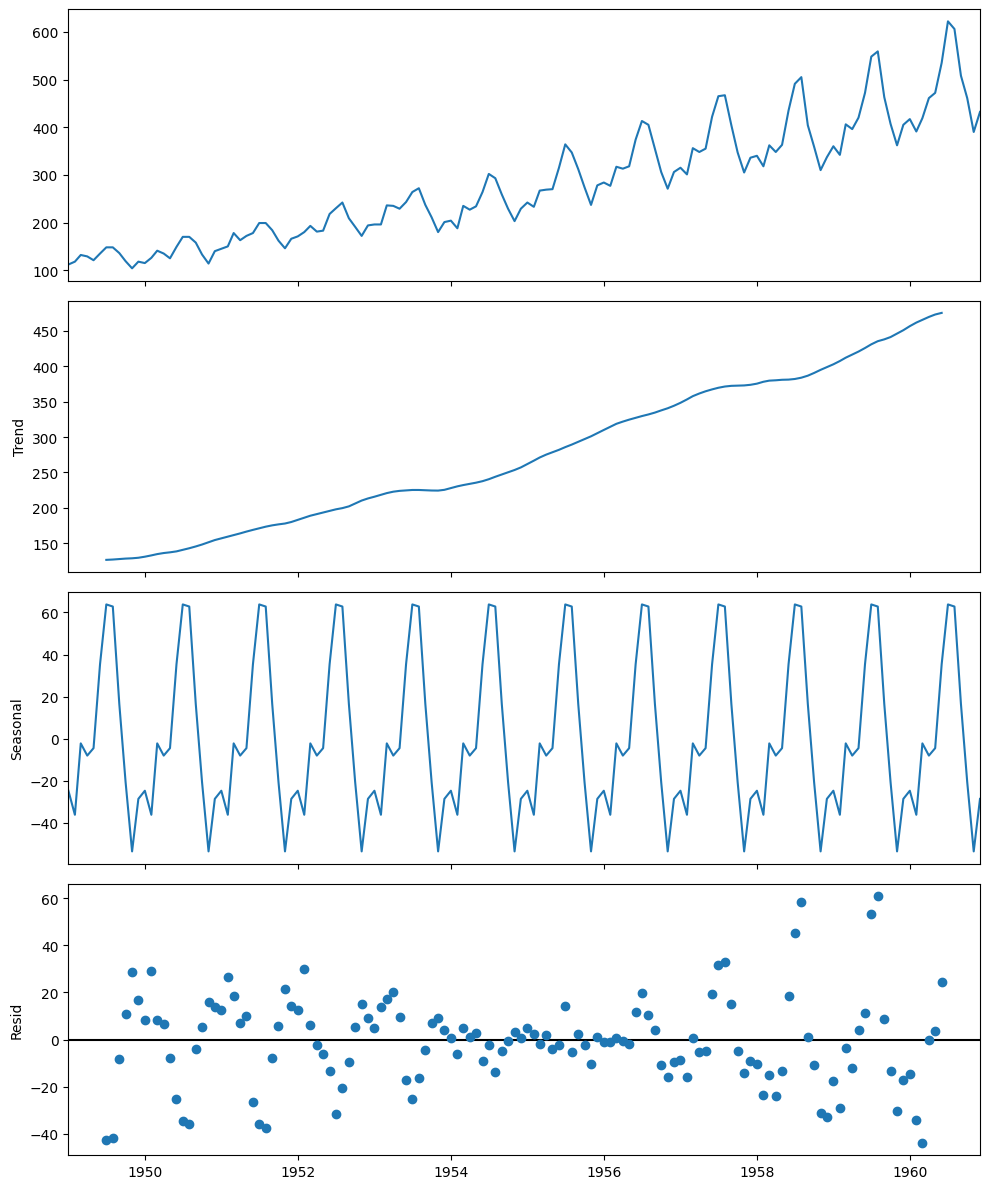

In [4]:
# Set the figure size
plt.rcParams['figure.figsize'] = [10, 12]

from statsmodels.tsa.seasonal import seasonal_decompose
# Plot the decomposition components
sd = seasonal_decompose(df).plot()

# RESHAPE DATA

- Reshape the data into an `n x (k + 1)` matrix where `n` is the number of samples and `k` is the number of features.
- Use the last 12 lags of the time series as features (i.e. set `k` equal to 12) in order to capture a full seasonal cycle.

In [5]:
k = 12

In [6]:
Z = []

for i in range(k + 1, df.shape[0] + 1):Z.append(df.iloc[(i - k - 1): i, 0])

Z = np.array(Z)

- The first 12 columns of `Z` are the features (lags).
- The last column of `Z` is the target.

In [7]:
Z.shape

(132, 13)

# SPLIT DATA

- Use the first 80% of the data for training and the remaining 20% of the data for testing.

In [9]:
split = int(0.8 * Z.shape[0])
print(split)
Z_train, Z_test = Z[:split, :], Z[split:, :]

105


# RESCALE DATA

- Extract the features (first 12 columns) and the target (last column).

In [10]:
X_train, y_train = Z_train[:, :-1], Z_train[:, -1]
X_test, y_test = Z_test[:, :-1], Z_test[:, -1]

- Plot the normalized training data.

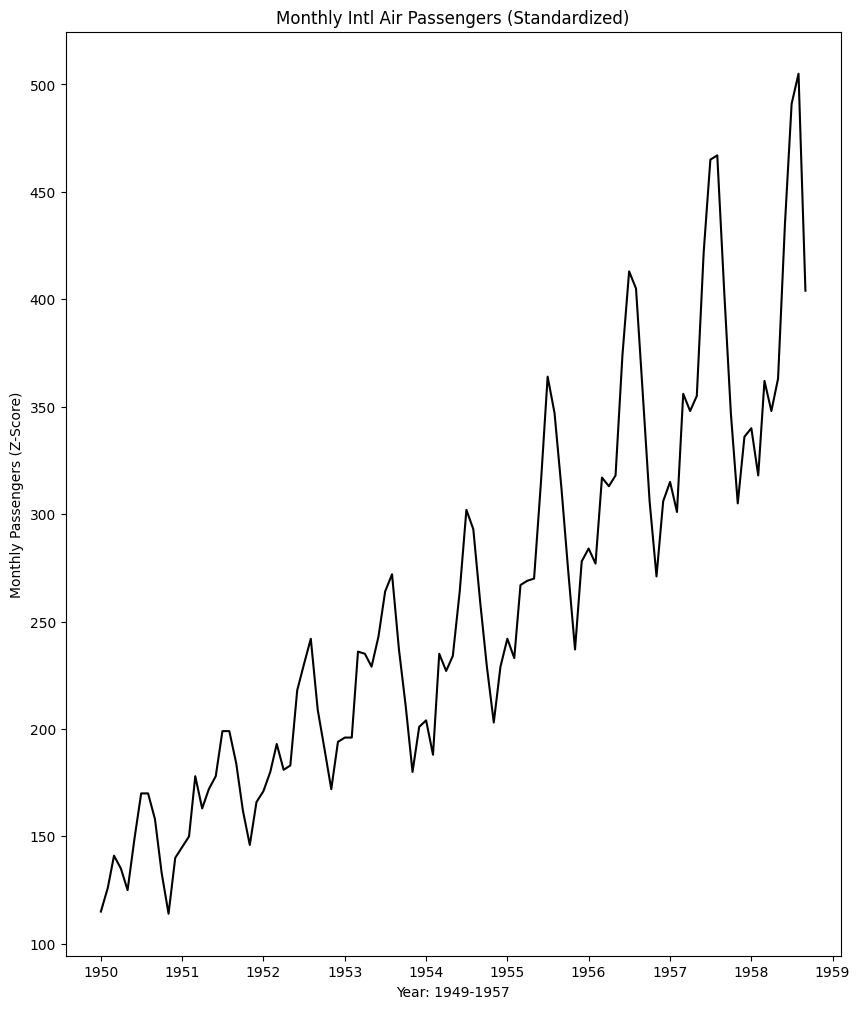

In [11]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (Z-Score)')
plt.title('Monthly Intl Air Passengers (Standardized)')
plt.plot(pd.Series(y_train, index=df.index[k: (k + len(y_train))]), color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

- Plot the normalized testing data.

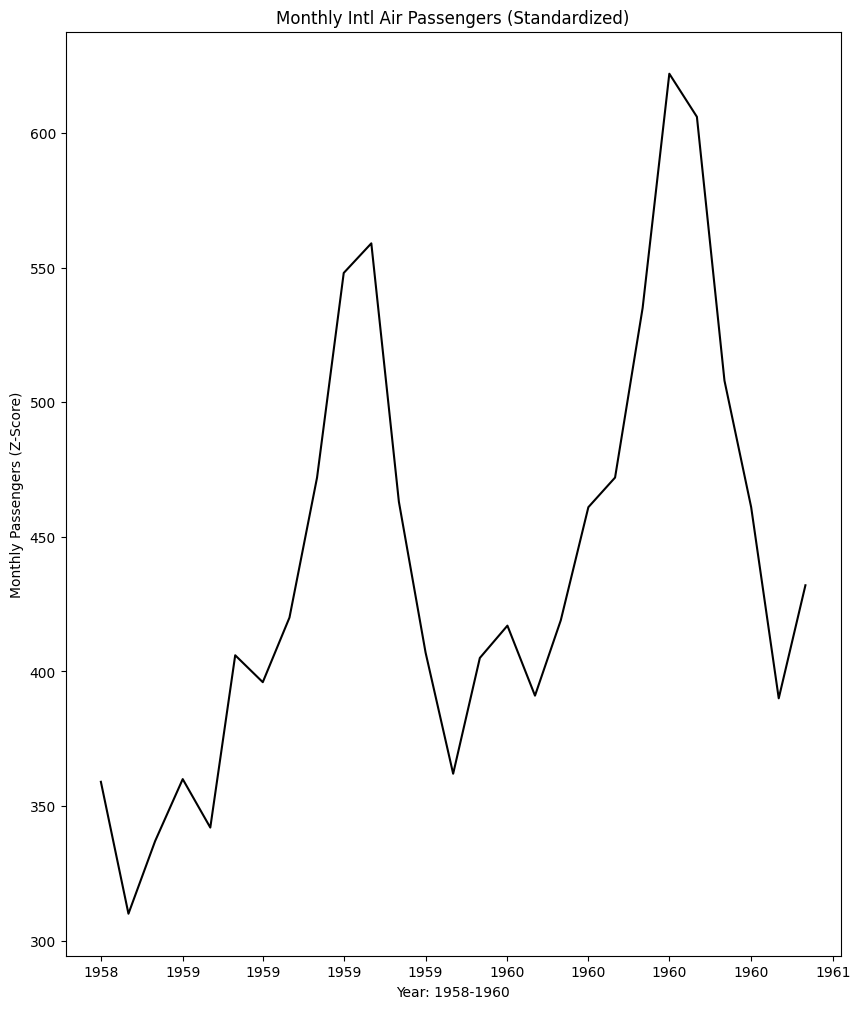

In [12]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1958-1960')
plt.ylabel('Monthly Passengers (Z-Score)')
plt.title('Monthly Intl Air Passengers (Standardized)')
plt.plot(pd.Series(y_test, index=df.index[-len(y_test):]), color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# FIT MLP USING 20% VALIDATION SET

- Use the last 20% of the training data for validation.

- Use the mean squared error (MSE) as validation loss.

In [13]:
def validation_loss(hidden_neurons):

    mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=1000, random_state=1)

    mlp.fit(X_train, y_train)

    return mean_squared_error(y_test, mlp.predict(X_test))

- Calculate the validation loss corresponding to different numbers of hidden nodes.

In [14]:
params = [10, 25, 50, 75, 100]
mse = [validation_loss(p) for p in params]

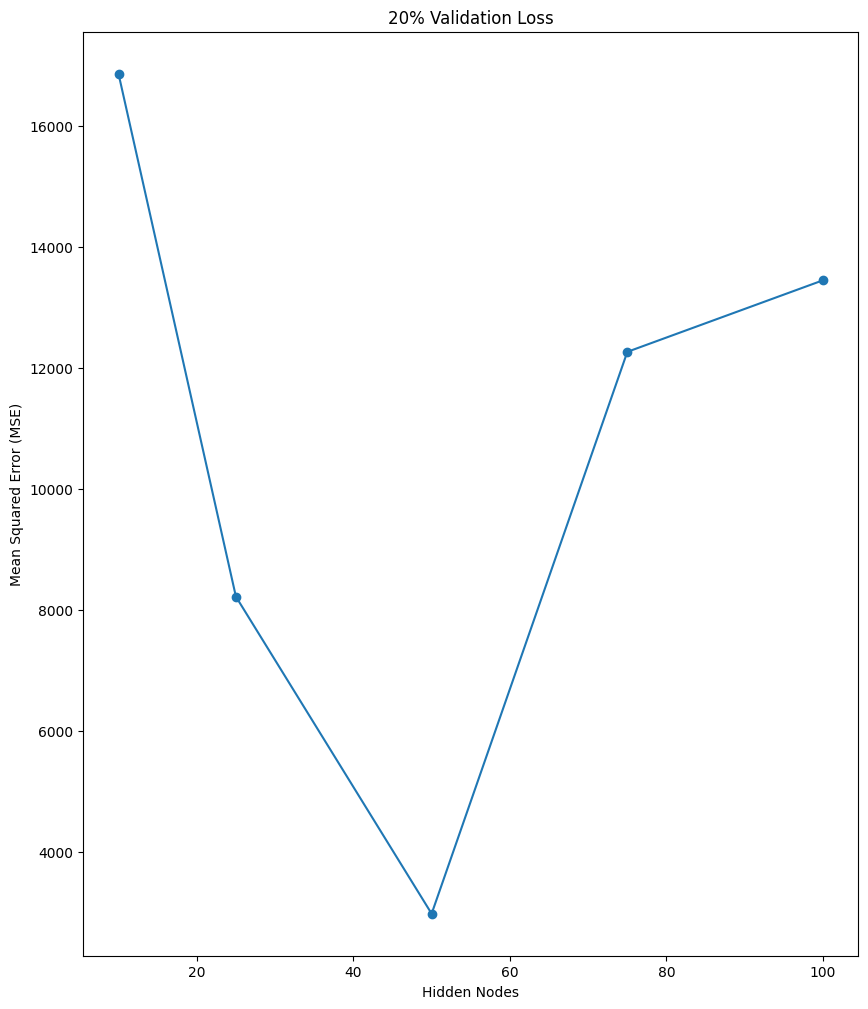

In [15]:
fig, ax = plt.subplots()
plt.xlabel('Hidden Nodes')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('20% Validation Loss')
plt.plot(params, mse, '-o')

- Find the number of hidden nodes associated with the smallest validation loss.

In [16]:
params[np.argmin(mse)]

50

- Fit an MLP model with 25 hidden nodes to the training data.

In [17]:
mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=1)

In [18]:
mlp.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=1)

In [19]:
print(mlp.score(X_train, y_train))

0.8901369838807179


- Use the fitted MLP model to forecast the test data.

In [20]:
y_pred = mlp.predict(X_test)

- Plot the data and the forecasts in the original scale.

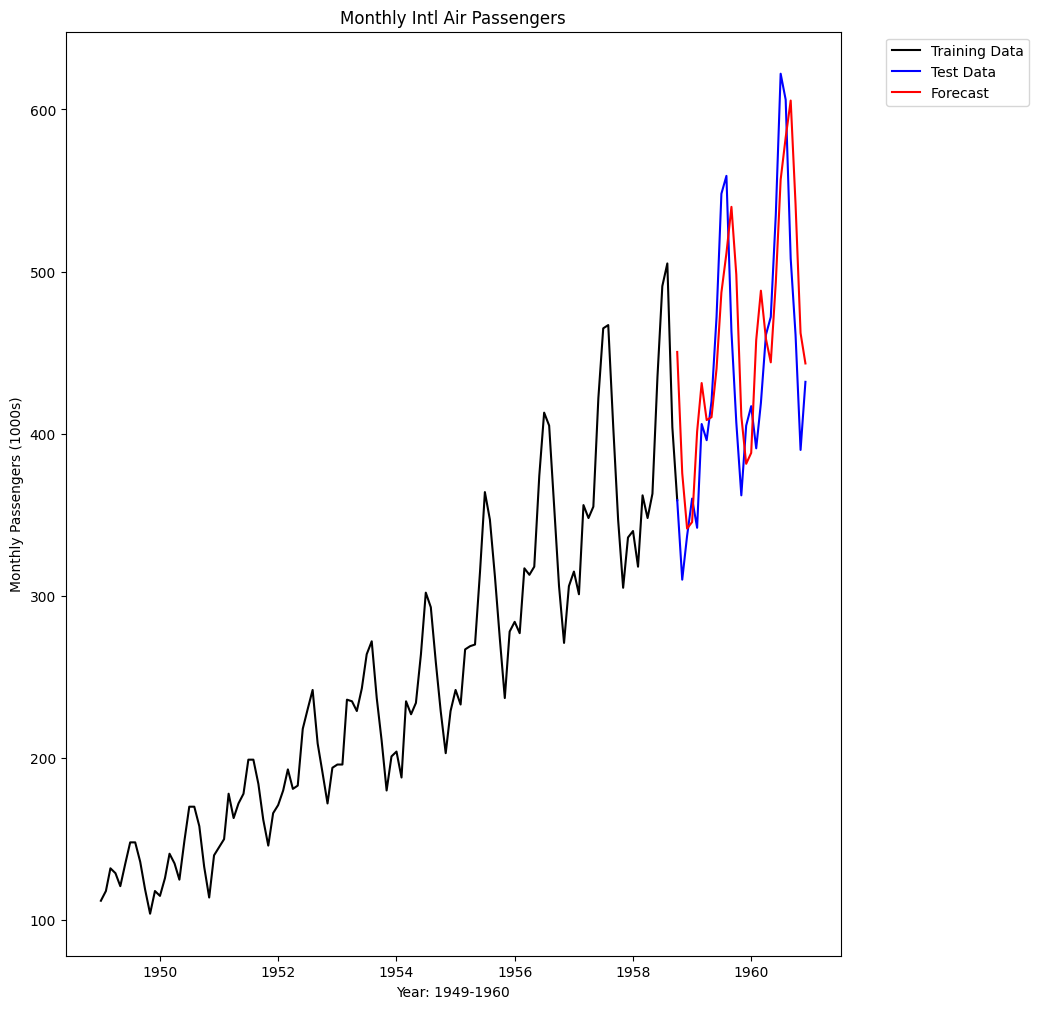

In [21]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(df.iloc[:(k + len(y_train) + 1), :], color='black', label='Training Data')
plt.plot(pd.Series(y_test, index=df.index[-len(y_test):]), color='blue', label='Test Data')
plt.plot(pd.Series(y_pred, index=df.index[-len(y_test):]), color='red', label='Forecast')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))